## Import Dependencies and set seed for reproducibility

Unfortunately, we cannot set the seed for the random initialisation of the model weights. This notebook is run on the first try and any change in the order or if an error occurs, the kernel should be restarted to reproduce results.

In [1]:
# import packages
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate

from tensorflow.keras.optimizers import Adam

# set seed
np.random.seed(1)
tf.random.set_seed(1)

## Read in the data and prepare it for model training
Due to the large size and time taken to recreate the dataframe, it has been saved as a pickle file for easy rerun of the code.

In [4]:
# read in the dataframe that we will be using
df = pd.read_pickle("final.pickle")

# set the dependent variable with an easy to remember and type name
df["outcome"] = df["vote_average"]

In [129]:
o = 1*len(df)+df['dislikeCount']

In [130]:
df['ratio']=df['likeCount']/o

In [268]:
df.head()

,imdb_id,twitter_text,id,average_interest,popularity,budget,revenue,original_title,cast,homepage,...,dislikeCount,favoriteCount,commentCount,youtube_text,index,youtube_polarity,twitter_polarity,image,outcome,ratio
0,369610,[mathand looming estimate online keep running ...,135397.0,10.130435,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,...,7224.0,0,13706,"[great official global trailer hd confusion, b...",369610,0.178097,0.067247,"[[[31.0, 58.0, 79.0], [32.0, 59.0, 80.0], [39....",6.5,11.528681
1,1392190,[liked youtube video max ost brother arm junki...,76341.0,10.617518,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,...,5653.0,0,13010,[look comment people probably love movie first...,1392190,0.220383,0.106874,"[[[20.0, 42.0, 56.0], [20.0, 42.0, 56.0], [20....",7.1,12.683991
2,2908446,[boerneaj want know kind soil fertile lack civ...,262500.0,9.771852,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,...,2536.0,0,6800,[reflect decade make trailer much good movie l...,2908446,0.069770,0.056846,"[[[63.0, 80.0, 87.0], [52.0, 69.0, 76.0], [55....",6.3,12.137214
3,2488496,"[monday meme war noguilt life noguilt life, le...",140607.0,5.788889,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,...,24451.0,0,117201,[disappointed withmovie isbest trailer ive eve...,2488496,0.091126,0.104194,"[[[8.0, 2.0, 2.0], [8.0, 2.0, 2.0], [8.0, 2.0,...",7.5,27.040452
4,2820852,[wiz khalifa see ft charlie puth official vide...,168259.0,17.764706,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,...,1533.0,0,2329,"[omg epic, song, race paradice paul walker, so...",2820852,0.114094,0.111469,"[[[254.0, 254.0, 252.0], [255.0, 255.0, 253.0]...",7.3,9.165653


## Split the data into train-test sets

In [270]:
# split and rename the training and target variables
training_data = df[["imdb_id", "twitter_polarity",
                    "average_interest","viewCount","likeCount","dislikeCount","youtube_polarity",
                    "commentCount", "youtube_text", "twitter_text","ratio"]]
target_data = df[["outcome"]]

In [271]:
# isolate the training data and target data
X = training_data[["twitter_polarity","average_interest","commentCount","youtube_polarity", "youtube_text","twitter_text"]]
y = target_data

# perform sklearn's train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## The final model consists of three branches, one for numeric data, and two for youtube and twitter data, respectively.

First, we split it into the numeric and text data. The text data will be further split later.

In [329]:
# train set
numeric_train = X_train[[
                        "twitter_polarity",
                         "average_interest",
                         "commentCount",
                         "youtube_polarity"
                        ]]
text_train = X_train[["youtube_text","twitter_text"]]

# test set 
numeric_test = X_test[[
                       "twitter_polarity",
                       "average_interest",
                       "commentCount",
                       "youtube_polarity"
                        ]]
text_test = X_test[["youtube_text","twitter_text"]]

## Further process the text data


In [273]:
# define transformer function to prepare text for the TFIDF vectioriser
def transform(arr):
    sentence = []
    for i in arr:
        sentence.append(i)
    return " ".join(sentence)

In [166]:
# transform the text data
X_train["youtube_text"] = X_train["youtube_text"].apply(lambda x: transform(x))
X_train["twitter_text"] = X_train["twitter_text"].astype(str).apply(lambda x: transform(x))
X_test["youtube_text"] = X_test["youtube_text"].apply(lambda x: transform(x))
X_test["twitter_text"] = X_test["twitter_text"].astype(str).apply(lambda x: transform(x))

C:\Users\Zenya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Zenya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Zenya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

## Vectorise our text data

In [167]:
# vectorise the text data using TFIDF vectorisation
vect1 = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range = (1,2), min_df = 3,max_df = 0.8, binary = True, max_features = 10000) # max vocab is 10000
vect2 = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range = (1,2), min_df = 3,max_df = 0.8, binary = True, max_features = 1000) # max vocab is 1000

docs_yt = vect1.fit_transform(X_train["youtube_text"]).todense()
docs_tweet = vect2.fit_transform(X_train["twitter_text"]).todense()
docs_test_yt = vect1.transform(X_test["youtube_text"]).todense()
docs_test_tweet = vect2.transform(X_test["twitter_text"]).todense()

## Further process our numeric data

In [243]:
# scaling numeric_data to mean 
scaler = StandardScaler()
scaler_X = scaler.fit(numeric_train)
numeric_train = scaler_X.transform(numeric_train)
numeric_test = scaler_X.transform(numeric_test)

## Define the multi-input neural network model

In [169]:
# define functions to create our textual model branches
def create_text_branch_youtube():
    model = Sequential()
    model.add(Dense(64, input_shape = (10000,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    return model

def create_text_branch_twitter():
    model = Sequential()
    model.add(Dense(64, input_shape = (1000,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    return model

In [170]:
# multilayer perceptron for numeric data
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="elu"))
    model.add(Dense(4, activation="elu"))
    if regress:
        model.add(Dense(1, activation="sigmoid"))
    return model

## Create the model and train it

In [330]:
# create the branches
mlp = create_mlp(numeric_train.shape[1], regress=False) # 4 dimensions
emb_yt = create_text_branch_youtube()
emb_tweet = create_text_branch_twitter()

#Uncomment out one of the input lines
#inputs = mlp.output
#inputs = emb_yt.output
#inputs = emb_tweet.output
#inputs = [emb_yt.output, emb_tweet.output]
#inputs = [mlp.output, emb_tweet.output]
#inputs = [mlp.output, emb_yt.output]
inputs = [mlp.output, emb_yt.output, emb_tweet.output]

# concatenate our multi-input model (comment out if only one input)
combinedInput = concatenate(inputs)

# create the rest of the model
x = Dense(64, activation="elu")(combinedInput)
#In the event that input is 1
#x = Dense(64, activation="elu")(inputs)
x = Dense(48, activation="elu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="elu")(x)
x = Dense(16, activation="elu")(x)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, emb_yt.input, emb_tweet.input], outputs=x)

# define the optimiser function
opt = Adam(lr=1e-3, decay=1e-3 / 200)

# define callbacks for training -- during training, save the best model, and stop training if loss does not show a 0.01 improvement after 10 epoches
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='bt4222_model', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=0)

# compile the model
model.compile(loss='mae', optimizer = opt)

# train
history = model.fit([numeric_train, docs_yt, docs_tweet], y_train, validation_split=0.1,
   epochs=50, batch_size=4, callbacks=[cp_callback, es_callback])

Train on 2184 samples, validate on 243 samples
Epoch 1/50
2184/2184 [==============================] - 6s 3ms/sample - loss: 2.5337 - val_loss: 0.7459
Epoch 2/50
2184/2184 [==============================] - 4s 2ms/sample - loss: 0.7782 - val_loss: 0.6800
Epoch 3/50
2184/2184 [==============================] - 2s 994us/sample - loss: 0.6534 - val_loss: 0.6897
Epoch 4/50
2184/2184 [==============================] - 4s 2ms/sample - loss: 0.5607 - val_loss: 0.6786
Epoch 5/50
2184/2184 [==============================] - 2s 966us/sample - loss: 0.5114 - val_loss: 0.7336
Epoch 6/50
2184/2184 [==============================] - 2s 1ms/sample - loss: 0.4737 - val_loss: 0.7182
Epoch 7/50
2184/2184 [==============================] - 2s 1ms/sample - loss: 0.4567 - val_loss: 0.7080


## Load the best model created during training, and test with the testing dataset

In [275]:
models = {}

In [331]:
# load model
model = tf.keras.models.load_model("bt4222_model")
# test the mean squared error value
test_acc = model.evaluate([numeric_test, docs_test_yt, docs_test_tweet], y_test)

809/809 [==============================] - 0s 247us/sample - loss: 0.6693


Run each one once to save the test accuracy of the feature that has been disabled.

In [304]:
models['No commentCount'] = test_acc

In [309]:
models['No averageInterest'] = test_acc

In [313]:
models['No twitterPolarity'] = test_acc

In [300]:
models['No ytPolarity'] = test_acc

In [277]:
models['Baseline'] = test_acc

In [332]:
models['No Twitter Tweets'] = test_acc

In [285]:
models['No YouTube Comments'] = test_acc

In [279]:
# obtain the predicted values
results = model.predict([numeric_test, docs_test_yt, docs_test_tweet])

## Take a quick preview of our predicted values

In [280]:
# our predicted values
print(min(results),max(results))

[4.4908004] [6.6384764]


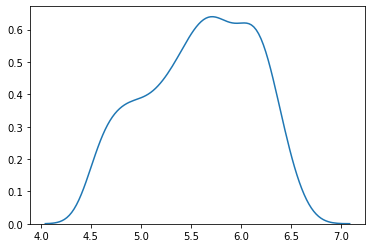

In [281]:
import seaborn as sns
sns.distplot(results, hist=False)

## Compare to actual values

In [227]:
# transform y_test into a similar format to the predicted values for easier comparison
y_test = np.stack(y_test['outcome']).reshape([-1,1])
print(min(y_test),max(y_test))

[2.4] [8.2]


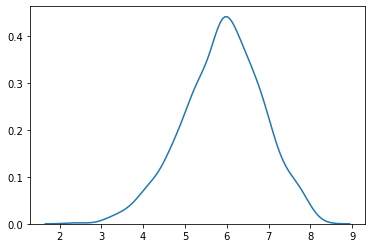

In [228]:
sns.distplot(y_test, hist=False)

In [21]:
# kills the gpu process to free any used memory (restart the kernel after this or other gpu processes will fail)
from numba import cuda
cuda.select_device(0)
cuda.close()

# Feature importance
We take a look at which of our features is the most important at predicting the popularity of a movie

In [322]:
difference = {}

In [333]:
for key in models.keys():
    difference[key] = models[key]-models['mlp, yt, twitter']

In [340]:
difference['Baseline'] = difference['mlp, yt, twitter']

In [346]:
df_models = pd.DataFrame(data=list(zip(difference.values(),difference.keys())), columns=['Loss','Features'])

In [347]:
df_models

,Loss,Features
0,0.037969,No ytPolarity
1,-0.005128,No commentCount
2,0.027796,No averageInterest
3,0.016795,No twitterPolarity
4,0.002149,No Twitter tweets
5,0.090771,No YouTube Comments
6,0.000000,Baseline


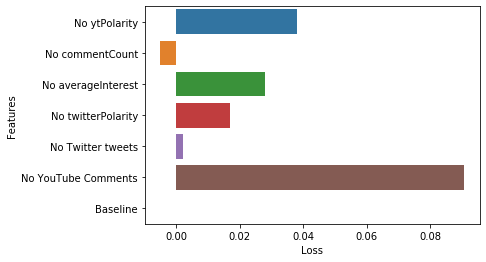

In [348]:
sns.barplot(y='Features', x='Loss', data=df_models, orient='h')